In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import os
os.environ['REQUESTS_CA_BUNDLE'] = ''

In [5]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# Change the classifier head 
class_names = ['Circlar Alopecia','Flees','Healthy','Runglong','Skin Lesions']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [6]:
from torchinfo import summary

summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 5]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [7]:
train_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/train'
test_dir = '/Users/chamidiperera/Documents/FYP Codes/datasets/Skin Datasets/test'

In [8]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)


  class_names = train_data.classes

  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [10]:

train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32)


In [11]:
from going_modular.going_modular import engine


optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4270 | train_acc: 0.8634 | test_loss: 0.4048 | test_acc: 0.8698
Epoch: 2 | train_loss: 0.1548 | train_acc: 0.9641 | test_loss: 0.2967 | test_acc: 0.8958
Epoch: 3 | train_loss: 0.1017 | train_acc: 0.9788 | test_loss: 0.2447 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.0750 | train_acc: 0.9860 | test_loss: 0.2182 | test_acc: 0.9323
Epoch: 5 | train_loss: 0.0587 | train_acc: 0.9903 | test_loss: 0.2000 | test_acc: 0.9375
Epoch: 6 | train_loss: 0.0478 | train_acc: 0.9926 | test_loss: 0.1918 | test_acc: 0.9505
Epoch: 7 | train_loss: 0.0400 | train_acc: 0.9946 | test_loss: 0.1904 | test_acc: 0.9453
Epoch: 8 | train_loss: 0.0335 | train_acc: 0.9965 | test_loss: 0.1840 | test_acc: 0.9453
Epoch: 9 | train_loss: 0.0295 | train_acc: 0.9956 | test_loss: 0.1825 | test_acc: 0.9479
Epoch: 10 | train_loss: 0.0248 | train_acc: 0.9979 | test_loss: 0.1800 | test_acc: 0.9531


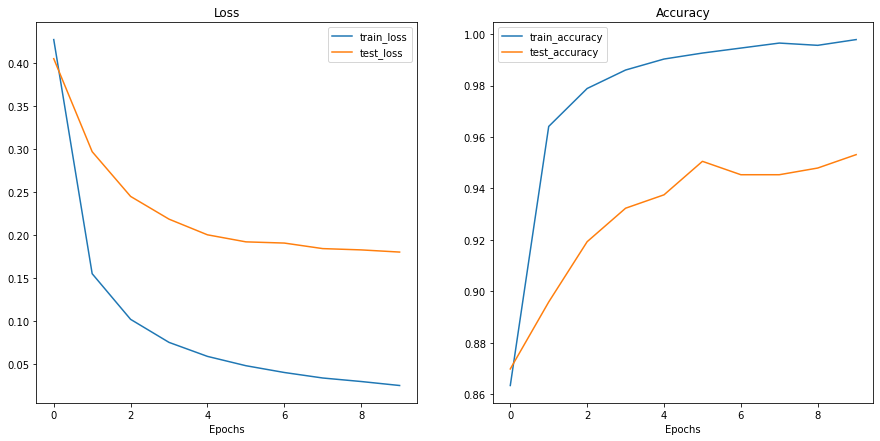

In [12]:

from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results) 

Class: circlar alopecia
Precision: 0.9347826086956522
Recall: 1.0
F1 Score: 0.9662921348314606

Class: flees
Precision: 1.0
Recall: 0.6875
F1 Score: 0.8148148148148148

Class: healthy
Precision: 0.8333333333333334
Recall: 0.7142857142857143
F1 Score: 0.7692307692307692

Class: runglong
Precision: 0.961038961038961
Recall: 0.9426751592356688
F1 Score: 0.9517684887459807

Class: skin lesions
Precision: 0.9619047619047619
Recall: 1.0
F1 Score: 0.9805825242718447



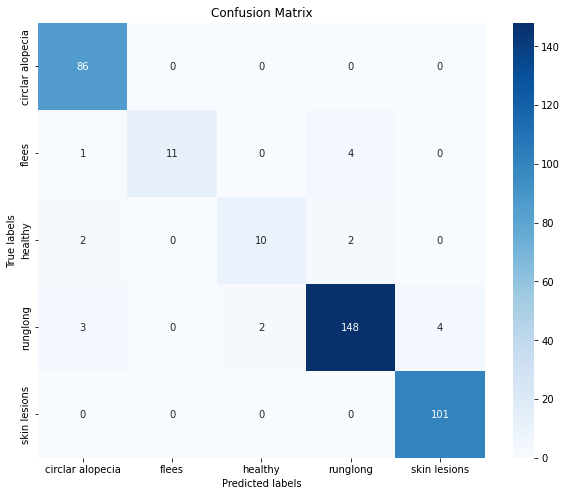

In [13]:

def calculate_metrics(model, test_dataloader, device):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    cm = confusion_matrix(y_true, y_pred)
    return precision, recall, f1, cm

precision, recall, f1, confusion_matrix = calculate_metrics(pretrained_vit, test_dataloader_pretrained, device)

for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print()

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


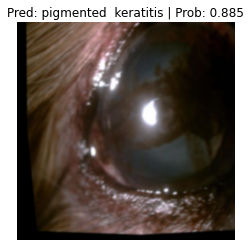

In [13]:
import requests

from going_modular.going_modular.predictions import pred_and_plot_image

custom_image_path = "/Users/chamidiperera/Downloads/Datasets/train/pigmented  keratitis/D0_31d86e47-60a5-11ec-8402-0a7404972c70_jpg.rf.55fa8bf3c9915fb046ae440e9bb54249.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

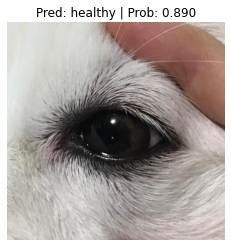

In [14]:

from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/Users/chamidiperera/Documents/4th year/machine vision/CW/healthy2.jpg"

pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [15]:

model_save_path = "pretrained_vit_eye_final.pth"
torch.save(pretrained_vit, model_save_path)

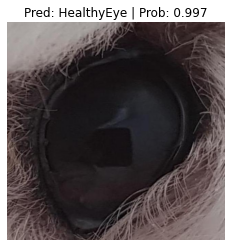

In [19]:
import requests
import torch
from going_modular.going_modular.predictions import pred_and_plot_image

class_names = ['Blepharitis','Conjunctivitis','Entropion','EyelidTumor','HealthyEye','Mastopathy','Nuclear Sclerosis','Pigmented Keratitis']

saved_model_path = "/Users/chamidiperera/Documents/FYP Codes/savedModels/skin/pretrained_vit_skin_final.pth"
pretrained_vit = torch.load(saved_model_path)

# Setup custom image path
custom_image_path = "/Users/chamidiperera/Downloads/Datasets/valid/healthy/D19_2ab64e33-60a5-11ec-8402-0a7404972c70_jpg.rf.ce98692b7e74aba98af231e030b11580.jpg"
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)


In [1]:
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super(VisionTransformer, self).__init__()
        self.encoder = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):

        return self.encoder(x)

    def get_last_conv_layer(self):

        return self.encoder[-1] 


In [8]:

pretrained_vit = VisionTransformer()


In [36]:
import torch
import torch.nn.functional as F

def get_last_conv_layer(model):

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            return module

def grad_cam(model, input_image, target_class):
  
    output = model(input_image)
    

    model.zero_grad()
    
 
    target_layer = get_last_conv_layer(model)
  
    output_class = output[:, target_class]
    

    gradients = torch.autograd.grad(outputs=output_class, inputs=target_layer.weight,
                                    grad_outputs=torch.ones_like(output_class),
                                    create_graph=True)[0]
    

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    activations = target_layer(input_image)

    for i in range(gradients.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]
    
  
    heatmap = torch.mean(activations, dim=1).squeeze()
    
    heatmap = F.relu(heatmap)
    
    return heatmap


In [22]:

def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)
    return image

In [72]:

image_path = '/Users/chamidiperera/Documents/4th year/machine vision/CW/healthy2.jpg'
input_image = preprocess_image(image_path)

In [73]:

target_class = 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


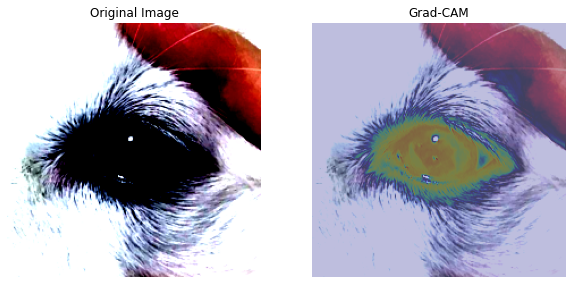

In [75]:

grad_cam_map = grad_cam(pretrained_vit, input_image, target_class)


grad_cam_map = (grad_cam_map - grad_cam_map.min()) / (grad_cam_map.max() - grad_cam_map.min())


grad_cam_map = grad_cam_map.detach().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(input_image.squeeze().numpy(), (1, 2, 0)))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grad_cam_map, cmap='jet', alpha=0.5)
plt.imshow(np.transpose(input_image.squeeze().numpy(), (1, 2, 0)), alpha=0.5)
plt.title('Grad-CAM')
plt.axis('off')

plt.show()

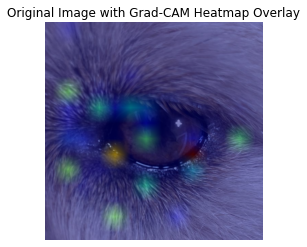

In [56]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import functional as F

def get_input_gradients(model, input_tensor, target_class):
    model.eval()
    input_tensor.requires_grad_()
    
    output = model(input_tensor)
    output = output[0, target_class]
    output.backward()
    
    gradients = input_tensor.grad.detach().cpu()
    return gradients

def preprocess(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),       

    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  
    return input_tensor


def grad_cam(model, input_image, target_class, feature_module, preprocess):
    model.eval()
    preprocessed_input = preprocess(input_image)
    

    with torch.no_grad():
        output = model(preprocessed_input)
    

    gradients = get_input_gradients(model, preprocessed_input, target_class)
    

    activations = feature_module(preprocessed_input)
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    

    weighted_activations = torch.zeros_like(activations)
    for i in range(min(activations.size(1), len(pooled_gradients))):
        weighted_activations[:, i, :, :] = activations[:, i, :, :] * pooled_gradients[i]
    

    heatmap = torch.sum(weighted_activations, dim=1).squeeze()
    
  
    heatmap = F.relu(heatmap)
    heatmap /= torch.max(heatmap)
    
    return heatmap.detach().cpu().numpy()

def plot_grad_cam(image_path, saved_model_path, class_names, preprocess, target_class=None, alpha=0.5):

    model = torch.load(saved_model_path)
    model.eval()

    if target_class is None:
        output = model(preprocess(image_path))
        _, target_class = torch.max(output, dim=1)
        target_class = target_class.item()
    
    conv_proj_layer = model.conv_proj 
    heatmap = grad_cam(model, image_path, target_class, conv_proj_layer, preprocess)
    

    image = Image.open(image_path).convert('RGB')
    preprocessed_image = preprocess(image_path)

    heatmap = Image.fromarray(np.uint8(plt.cm.jet(heatmap)*255))
    heatmap = heatmap.resize((image.width, image.height), Image.BILINEAR) 
    heatmap = np.array(heatmap.convert("RGB"))
    
    
    overlayed_image = cv2.addWeighted(np.array(image), 1-alpha, heatmap, alpha, 0)
    

    plt.imshow(overlayed_image)
    plt.title('Original Image with Grad-CAM Heatmap Overlay')
    plt.axis('off')
    plt.show()


import cv2

saved_model_path = "/Users/sandundesilva/Downloads/Datasets/ViT/pretrained_vit_eye_final.pth"
custom_image_path = "/Users/sandundesilva/Downloads/Datasets/valid/healthy/D0_29d852c2-60a5-11ec-8402-0a7404972c70_jpg.rf.d0aad08374079534213449981b544613.jpg"
class_names = ['Blepharitis', 'Conjunctivitis', 'Entropion', 'EyelidTumor', 'HealthyEye', 'Mastopathy', 'Nuclear Sclerosis', 'Pigmented Keratitis']
plot_grad_cam(custom_image_path, saved_model_path, class_names, preprocess)




In [57]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import shap

# Define your preprocess function
def preprocess(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to match the expected input size
        transforms.ToTensor(),          # Convert the image to a PyTorch tensor
        # Add normalization if required
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # Add an extra dimension for batch size
    return input_tensor

# Load your PyTorch model
model = torch.load(saved_model_path)
model.eval()

# Wrap your PyTorch model using SHAP with appropriate max_evals
explainer = shap.Explainer(model, preprocess, algorithm='permutation', max_evals='auto')

# Load and preprocess your data
image_path = "/Users/sandundesilva/Downloads/Datasets/valid/healthy/D0_0ac472c9-60a5-11ec-8402-0a7404972c70_png.rf.99962b148c62fbcb0f75694b576ccda0.jpg"
image_tensor = preprocess(image_path)

# Generate SHAP values
shap_values = explainer(image_tensor)

# Visualize SHAP explanations
shap.image_plot(shap_values)
